In [165]:
# from google.colab import drive
# drive.mount('/content/drive')


# # To make this command work you need to add the folder data_assignment_2 to the root of your Google Drive 
# # Don't forget to upload the actual files there too
# # The best way to do this is the upload the data assignment zip and unzip the files in Google Drive. 
# # It kinda sucks but its one of the few ways to use Google Colab
# # When we turn this in, we might have to directly link to data so it can be run locally 
# %cd /content/drive/MyDrive/data_assignment_2

In [22]:
# Sanity check 
import os
print(os.listdir())


['.git', '.gitattributes', '.gitignore', 'data_assignment.ipynb', 'README.md', 'TTGT_quotes_2019.csv', 'TTGT_quotes_2020.csv', 'TTGT_trades_2019.csv', 'TTGT_trades_2020.csv']


In [23]:
# Should be done within a minute on newer machines 
# I'm not sure if we should store the data files in a dict.
import pandas as pd
import numpy as np
df_dict = dict()
for file in os.listdir():
  if file[-4:] == ".csv":
    df_dict[file] = pd.read_csv(file)


In [24]:
#Taking only necessary columns

df_dict["TTGT_quotes_2019.csv"] = df_dict["TTGT_quotes_2019.csv"][['DATE', 'TIME_M', 'BID', 'BIDSIZ', 'ASK']]
df_dict["TTGT_quotes_2020.csv"] = df_dict["TTGT_quotes_2020.csv"][['DATE', 'TIME_M', 'BID', 'BIDSIZ', 'ASK']]
df_dict["TTGT_trades_2019.csv"] = df_dict["TTGT_trades_2019.csv"][['DATE', 'TIME_M', 'PRICE', 'SIZE']]
df_dict["TTGT_trades_2020.csv"] = df_dict["TTGT_trades_2020.csv"][['DATE', 'TIME_M', 'PRICE', 'SIZE']]
print(df_dict["TTGT_quotes_2019.csv"].columns)
print(df_dict["TTGT_quotes_2019.csv"].iloc[0][0])
print(df_dict["TTGT_quotes_2019.csv"].iloc[0][1])
print(df_dict["TTGT_trades_2019.csv"].columns)
print(df_dict["TTGT_trades_2019.csv"].iloc[0][0])
print(df_dict["TTGT_trades_2019.csv"].iloc[0][1])





Index(['DATE', 'TIME_M', 'BID', 'BIDSIZ', 'ASK'], dtype='object')
20190102
4:00:00.032946263
Index(['DATE', 'TIME_M', 'PRICE', 'SIZE'], dtype='object')
20190102
9:30:00.362466984


In [25]:
#trim milliseconds/seconds from time
for df in df_dict:
    if 'quotes' in df:
        df_dict[df]['TIME_M'] = df_dict[df]['TIME_M'].apply(lambda x: x[:-10])
    else:
        df_dict[df]['TIME_M'] = df_dict[df]['TIME_M'].apply(lambda x: x[:-13])

In [26]:
#check work
#print(df_dict["TTGT_quotes_2019.csv"].sort_values(by = ['DATE','TIME_M']))
#print(df_dict["TTGT_quotes_2019.csv"].groupby(['DATE', 'TIME_M'], as_index = False).mean().sort_values(by = ['DATE','TIME_M']))

#print(df_dict["TTGT_trades_2019.csv"].sort_values(by = ['DATE','TIME_M']))
#print(df_dict["TTGT_trades_2019.csv"].groupby(['DATE', 'TIME_M'], as_index = False).agg({'PRICE':'mean','SIZE':'sum'}).sort_values(by = ['DATE','TIME_M']))

Now we will aggregate the tables

In [27]:
#Average from milliseconds to seconds on quotes
df_dict["TTGT_quotes_2019.csv"] = df_dict["TTGT_quotes_2019.csv"].groupby(['DATE', 'TIME_M'], as_index = False).mean()
df_dict["TTGT_quotes_2020.csv"] = df_dict["TTGT_quotes_2020.csv"].groupby(['DATE', 'TIME_M'], as_index = False).mean()
#Averaging from seconds to minutes on trades
df_dict["TTGT_trades_2019.csv"] = df_dict["TTGT_trades_2019.csv"].groupby(['DATE', 'TIME_M'], as_index = False).agg({'PRICE':'mean','SIZE':'sum'})
df_dict["TTGT_trades_2020.csv"] = df_dict["TTGT_trades_2020.csv"].groupby(['DATE', 'TIME_M'], as_index = False).agg({'PRICE':'mean','SIZE':'sum'})

In [28]:
#getting weighted average on quotes
for df in df_dict:
    if 'quotes' in df:
        df_dict[df]['SECONDS'] = df_dict[df]['TIME_M'].apply(lambda x: x[-2:])
        df_dict[df]['TIME_M'] = df_dict[df]['TIME_M'].apply(lambda x: x[:-3])

In [30]:
#setting up the weights for weighted average
def generateWeights(df):
    weights = []
    currdate = None
    currtime = None
    prevSec = None
    for _, row in df.iterrows():
        date, time, second = row['DATE'], row['TIME_M'], row['SECONDS']
        if date != currdate:
            currdate = date
            currtime = time
            if prevSec != None:
                weights.append(60 - int(prevSec))
            prevSec = second
        else:
            if time != currtime:
                currtime = time
                weights.append(60-int(prevSec))
                prevSec = second
            else:
                weights.append(int(second) - int(prevSec))
                prevSec = second
    weights.append(60-int(prevSec))
    return weights

weights1 = generateWeights(df_dict["TTGT_quotes_2019.csv"])
weights2 = generateWeights(df_dict["TTGT_quotes_2020.csv"])


In [38]:
#Calculating weighted average

#Weighted average function
def weightedAverage(df):
    wm = lambda x: np.average(x, weights=df.loc[x.index, "WEIGHTS"])
    df = df.groupby(["DATE", "TIME_M"], as_index = False).agg(
        BID = ("BID", wm),
        BIDSIZ = ("BIDSIZ", wm),
        ASK = ("ASK",wm)
    )
    return df

#Setup 2019 and 2020 weights
df_dict["TTGT_quotes_2019.csv"]['WEIGHTS'] = pd.Series(weights1, index=df_dict["TTGT_quotes_2019.csv"].index)
df_dict["TTGT_quotes_2020.csv"]['WEIGHTS'] = pd.Series(weights2, index=df_dict["TTGT_quotes_2020.csv"].index)

df_dict["TTGT_quotes_2019.csv"] = weightedAverage(df_dict["TTGT_quotes_2019.csv"])
df_dict["TTGT_quotes_2020.csv"] = weightedAverage(df_dict["TTGT_quotes_2020.csv"])


In [48]:
#sanity check
#print(df_dict["TTGT_quotes_2019.csv"])
#print(df_dict["TTGT_quotes_2020.csv"])
#print(df_dict["TTGT_trades_2019.csv"])
#print(df_dict["TTGT_trades_2020.csv"])
#print(df_dict["TTGT_trades_2020.csv"][["DATE","TIME_M"]])

           DATE TIME_M
0      20200102  10:00
1      20200102  10:01
2      20200102  10:02
3      20200102  10:03
4      20200102  10:04
...         ...    ...
83012  20201231   9:54
83013  20201231   9:55
83014  20201231   9:57
83015  20201231   9:58
83016  20201231   9:59

[83017 rows x 2 columns]


Plotting portion

In [40]:
#Instantiate plotting

from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt


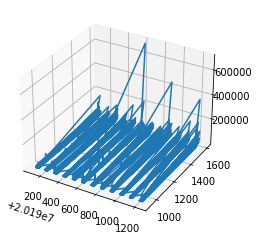

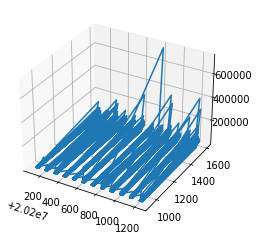

In [44]:
#PROBLEM 1: Volume Plot
required_data = df_dict["TTGT_trades_2019.csv"].copy()
required_data['TIME_M'] = required_data['TIME_M'].apply(lambda x: int(x.replace(':','')))
required_data = required_data[required_data['TIME_M'].between(930, 1600)]
x = required_data['DATE']
y = required_data['TIME_M']
z = required_data['SIZE']


fig = plt.figure()
ax = plt.axes(projection ='3d')

# syntax for 3-D projection
ax = plt.axes(projection ='3d')
 

ax.plot3D(x, y, z)
fig.show()

required_data = df_dict["TTGT_trades_2020.csv"].copy()
required_data['TIME_M'] = required_data['TIME_M'].apply(lambda x: int(x.replace(':','')))
required_data = required_data[required_data['TIME_M'].between(930, 1600)]
x = required_data['DATE']
y = required_data['TIME_M']
z = required_data['SIZE']


fig = plt.figure()
ax = plt.axes(projection ='3d')

# syntax for 3-D projection
ax = plt.axes(projection ='3d')
 

ax.plot3D(x, y, z)
fig.show()


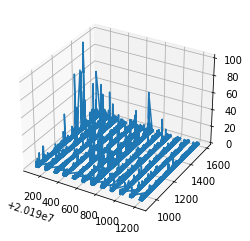

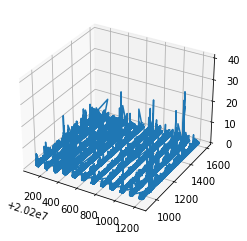

In [43]:
#PROBLEM 3: Bid Order Size
required_data = df_dict["TTGT_quotes_2019.csv"].copy()
required_data['TIME_M'] = required_data['TIME_M'].apply(lambda x: int(x.replace(':','')))
required_data = required_data[required_data['TIME_M'].between(930, 1600)]
x = required_data['DATE']
y = required_data['TIME_M']
z = required_data['BIDSIZ']


fig = plt.figure()
ax = plt.axes(projection ='3d')

# syntax for 3-D projection
ax = plt.axes(projection ='3d')
 

ax.plot3D(x, y, z)
fig.show()

required_data = df_dict["TTGT_quotes_2020.csv"].copy()
required_data['TIME_M'] = required_data['TIME_M'].apply(lambda x: int(x.replace(':','')))
required_data = required_data[required_data['TIME_M'].between(930, 1600)]
x = required_data['DATE']
y = required_data['TIME_M']
z = required_data['BIDSIZ']


fig = plt.figure()
ax = plt.axes(projection ='3d')

# syntax for 3-D projection
ax = plt.axes(projection ='3d')
 

ax.plot3D(x, y, z)
fig.show()
